In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import pandas as pd

style.use('default')
import matplotlib.path as mpath

In [50]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'
variables = ['photoC_TOT_zint','zoo1C','zoo2C','zoo3C','zoo4C','diatC','x_graze_zoo3_zint','x_graze_zoo4_zint','photoC_diat_zint','photoC_sp_zint']
coords = {'x':'TLONG','y':'TLAT'}
keepthese = ['z_t','time_bound','TAREA','REGION_MASK', 'time'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']

#### get case

In [51]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004
photoC_TOT_zint
zoo1C
zoo2C
zoo3C
zoo4C
diatC
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_diat_zint
photoC_sp_zint
CPU times: user 6.98 s, sys: 2.85 s, total: 9.83 s
Wall time: 11.9 s


In [52]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['HTLfood_zint'] = ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.x_graze_zoo3_zint / ds.photoC_TOT_zint
ds['zratio'] = tmp

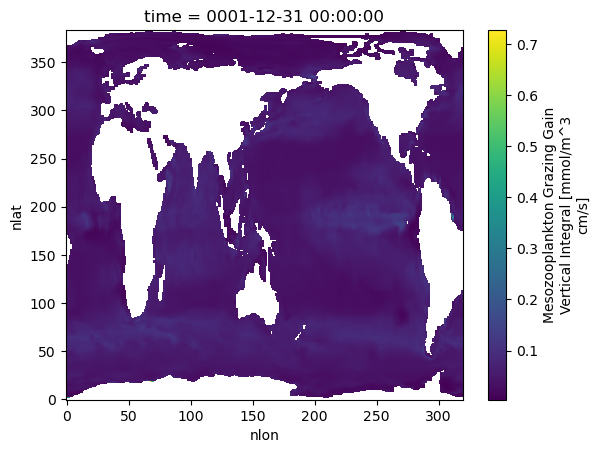

In [53]:
ds.zratio.isel(time=0).plot()

In [54]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1.e-4
depths=ds_grid.z_t * 0.01
tlen=len(ds.time)
years = np.arange(1958,1958+tlen,1)
years

array([1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018])

### plotting function (helps with South Pole stereographic map)

In [55]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Do correlations NPP and HTL vars

In [29]:
%%time
zoo4C_NPP_ann_corr = xr.corr(ds.zoo4C_zint, ds.photoC_TOT_zint, dim='time')
zoo4C_NPP_ann_corr = zoo4C_NPP_ann_corr.squeeze()

CPU times: user 1.22 s, sys: 2.47 s, total: 3.69 s
Wall time: 3.62 s


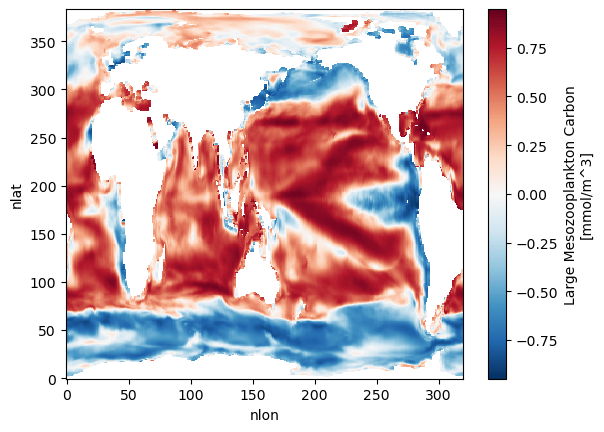

In [30]:
zoo4C_NPP_ann_corr.plot()

In [33]:
%%time
zratio_NPP_ann_corr = xr.corr(ds.zratio, ds.photoC_TOT_zint, dim='time')
zratio_NPP_ann_corr = zratio_NPP_ann_corr.squeeze()

CPU times: user 256 ms, sys: 157 ms, total: 413 ms
Wall time: 422 ms


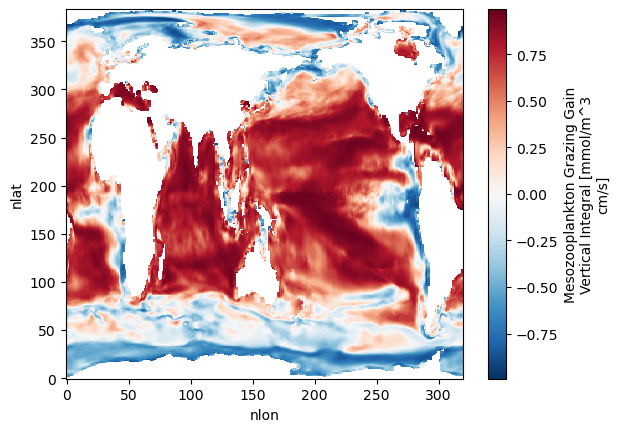

In [34]:
zratio_NPP_ann_corr.plot()

In [42]:
%%time
zoo3C_NPP_ann_corr = xr.corr(ds.zoo3C_zint, ds.photoC_TOT_zint, dim='time')
zoo3C_NPP_ann_corr = zoo3C_NPP_ann_corr.squeeze()

CPU times: user 1.32 s, sys: 2.56 s, total: 3.88 s
Wall time: 3.79 s


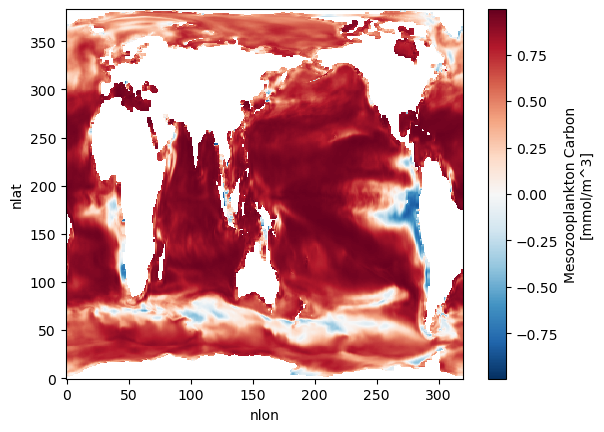

In [43]:
zoo3C_NPP_ann_corr.plot()

### Correlations between NPP and other biomass/production

In [44]:
%%time
zoo2C_NPP_ann_corr = xr.corr(ds.zoo2C_zint, ds.photoC_TOT_zint, dim='time')
zoo2C_NPP_ann_corr = zoo2C_NPP_ann_corr.squeeze()

CPU times: user 1.3 s, sys: 2.51 s, total: 3.81 s
Wall time: 3.94 s


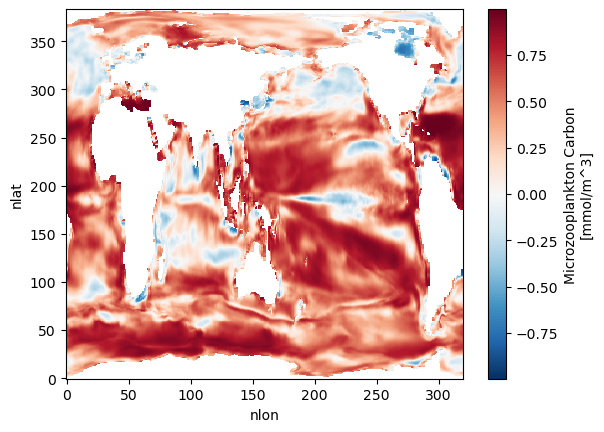

In [45]:
zoo2C_NPP_ann_corr.plot()

In [46]:
%%time
zoo1C_NPP_ann_corr = xr.corr(ds.zoo1C_zint, ds.photoC_TOT_zint, dim='time')
zoo1C_NPP_ann_corr = zoo1C_NPP_ann_corr.squeeze()

CPU times: user 1.33 s, sys: 2.73 s, total: 4.06 s
Wall time: 4.25 s


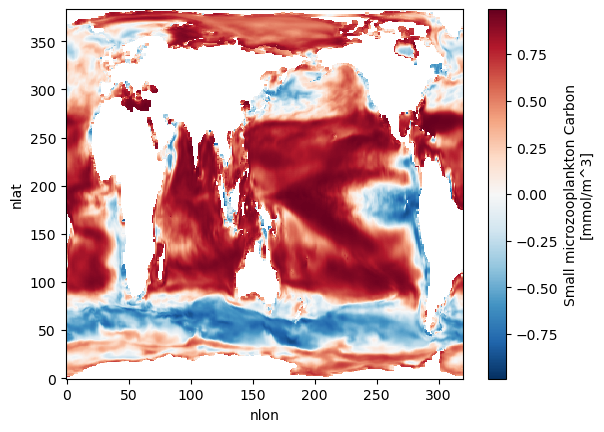

In [47]:
zoo1C_NPP_ann_corr.plot()

In [48]:
%%time
diatC_NPP_ann_corr = xr.corr(ds.diatC_zint, ds.photoC_TOT_zint, dim='time')
diatC_NPP_ann_corr = diatC_NPP_ann_corr.squeeze()

CPU times: user 1.25 s, sys: 2.71 s, total: 3.96 s
Wall time: 4.09 s


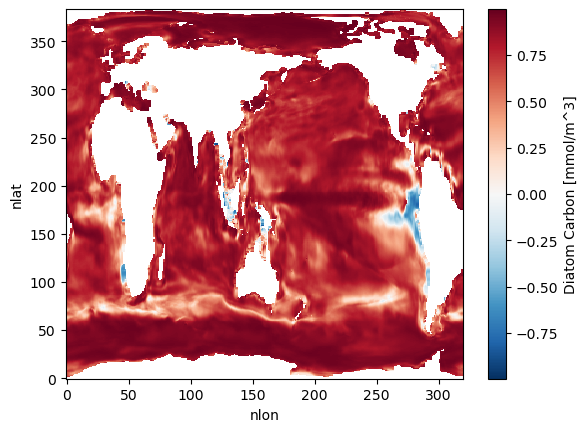

In [49]:
diatC_NPP_ann_corr.plot()

In [56]:
%%time
diatNPP_NPP_ann_corr = xr.corr(ds.photoC_diat_zint, ds.photoC_TOT_zint, dim='time')
diatNPP_NPP_ann_corr = diatNPP_NPP_ann_corr.squeeze()

CPU times: user 273 ms, sys: 317 ms, total: 590 ms
Wall time: 634 ms


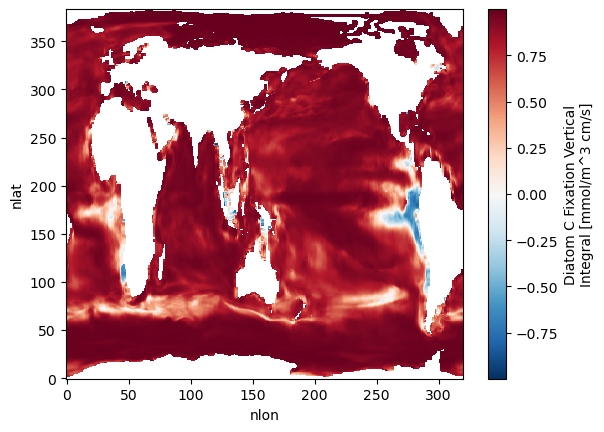

In [57]:
diatNPP_NPP_ann_corr.plot()

In [58]:
%%time
spNPP_NPP_ann_corr = xr.corr(ds.photoC_sp_zint, ds.photoC_TOT_zint, dim='time')
spNPP_NPP_ann_corr = spNPP_NPP_ann_corr.squeeze()

CPU times: user 276 ms, sys: 227 ms, total: 503 ms
Wall time: 653 ms


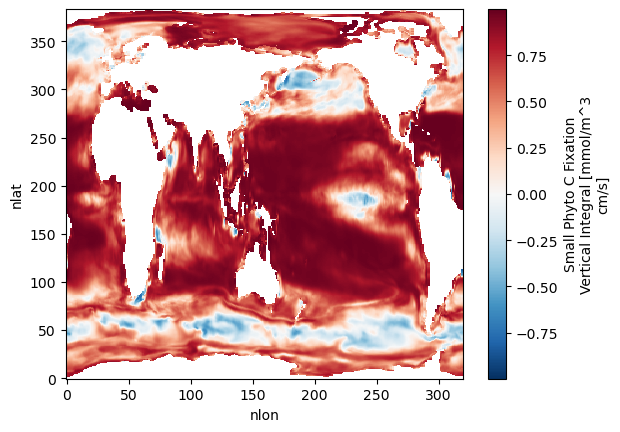

In [59]:
spNPP_NPP_ann_corr.plot()

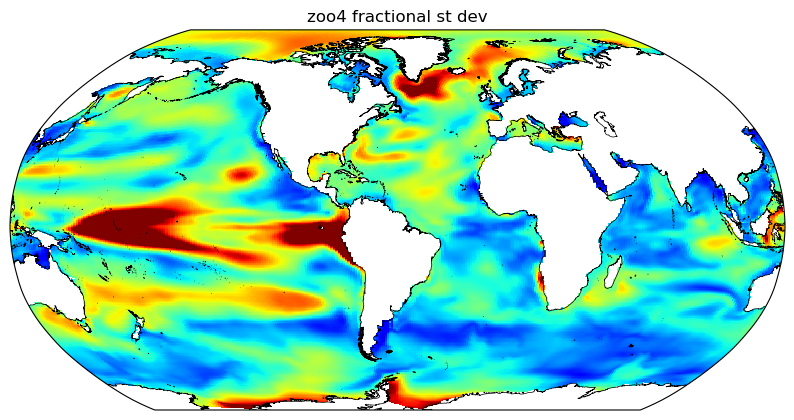

In [20]:
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_zoo4)

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo4 fractional st dev', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.15,transform=ccrs.PlateCarree())

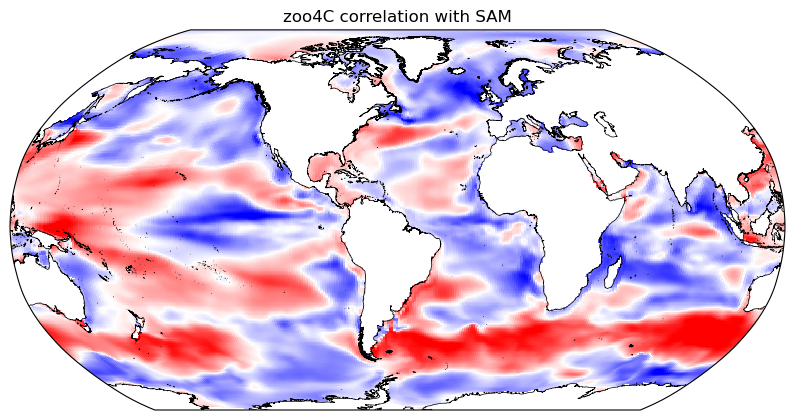

In [21]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_sam_ann_corr)

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo4C correlation with SAM', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.6,vmax=0.6,transform=ccrs.PlateCarree())

### zoo3 plots

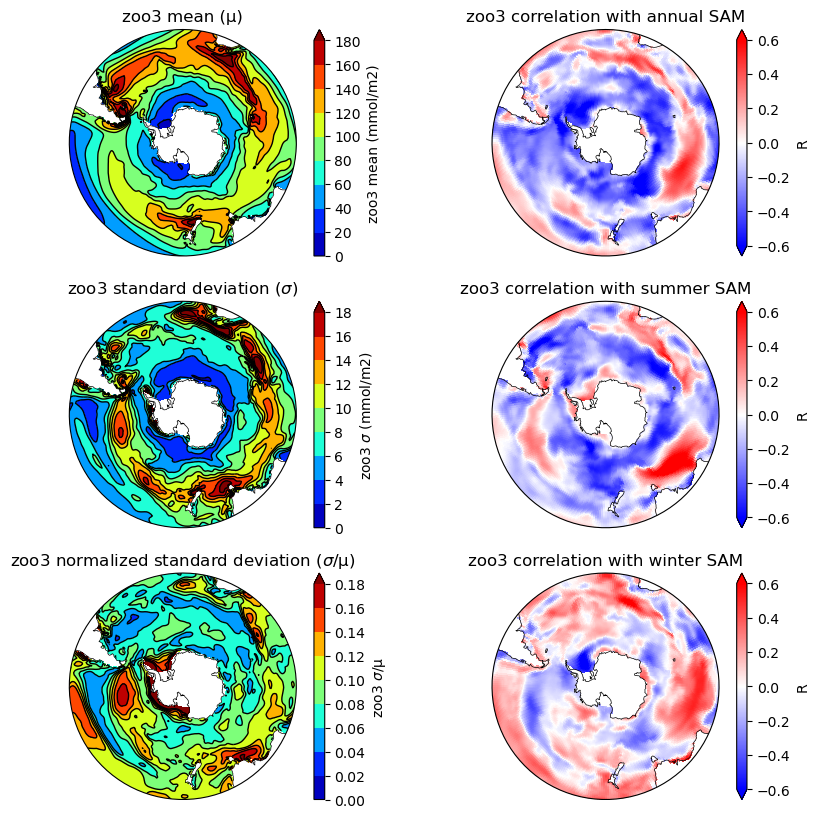

In [22]:
fig = plt.figure(figsize=(10,10))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, mean_zoo3)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,200,20)}

ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 mean (µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo3 mean (mmol/m2)')

#----------PLOT ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_zoo3)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,20,2)}

ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 standard deviation (${\sigma}$)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo3 ${\sigma}$ (mmol/m2)')

#----------PLOT MEAN/ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_zoo3)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.2,0.02)}

ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 normalized standard deviation (${\sigma}$/µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo3 ${\sigma}$/µ')

#----------PLOT SAM annual correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo3_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM summer correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo3_sam_sum_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 correlation with summer SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM winter correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo3_sam_win_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 correlation with winter SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### Microzooplankton (zoo1 + zoo4)

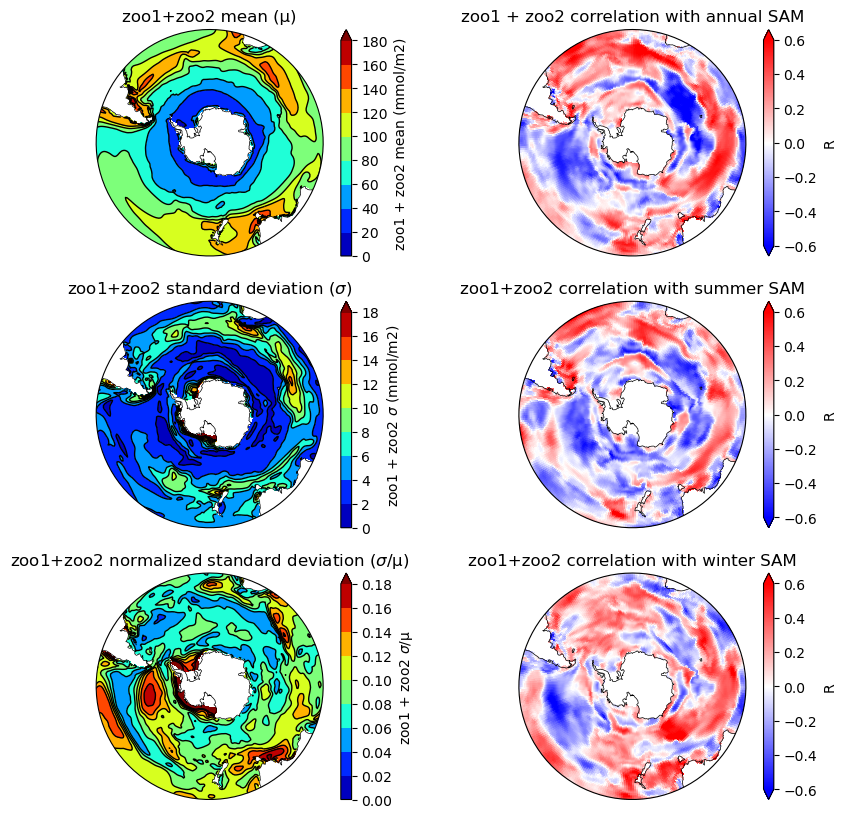

In [23]:
fig = plt.figure(figsize=(10,10))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, mean_zoo1_2)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,200,20)}

ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1+zoo2 mean (µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo1 + zoo2 mean (mmol/m2)')

#----------PLOT ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_zoo1_2)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,20,2)}

ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1+zoo2 standard deviation (${\sigma}$)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo1 + zoo2 ${\sigma}$ (mmol/m2)')

#----------PLOT MEAN/ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_zoo3)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.2,0.02)}

ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1+zoo2 normalized standard deviation (${\sigma}$/µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo1 + zoo2 ${\sigma}$/µ')

#----------PLOT SAM annual correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo1_2_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1 + zoo2 correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM summer correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo1_2_sam_sum_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1+zoo2 correlation with summer SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM winter correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo1_2_sam_win_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1+zoo2 correlation with winter SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### diatom plots

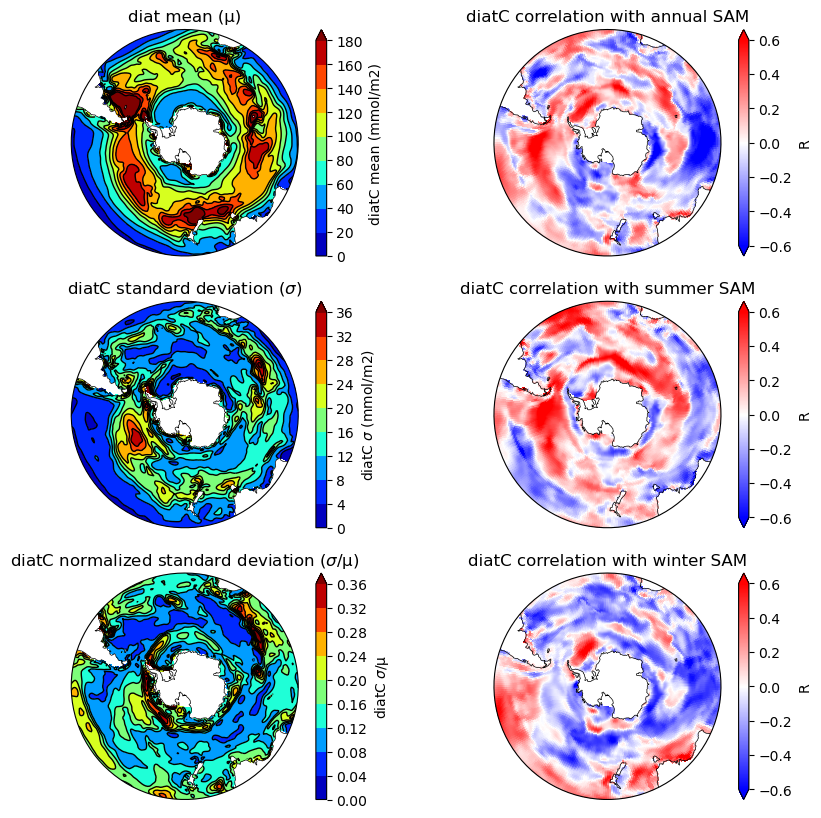

In [24]:
fig = plt.figure(figsize=(10,10))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, mean_diat)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,200,20)}

ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('diat mean (µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='diatC mean (mmol/m2)')

#----------PLOT ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_diat)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,40,4)}

ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC standard deviation (${\sigma}$)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='diatC ${\sigma}$ (mmol/m2)')

#----------PLOT MEAN/ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_diat)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.4,0.04)}

ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC normalized standard deviation (${\sigma}$/µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='diatC ${\sigma}$/µ')

#----------PLOT SAM annual correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, diat_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM summer correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, diat_sam_sum_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC correlation with summer SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM winter correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, diat_sam_win_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC correlation with winter SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### A few other correlations

In [25]:
zoo4_ifrac_corr = xr.corr(ds.zoo4C_zint, ds.IFRAC, dim='time')

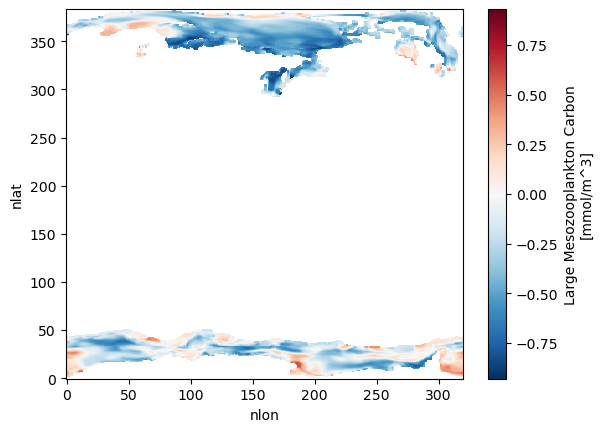

In [26]:
zoo4_ifrac_corr.plot()

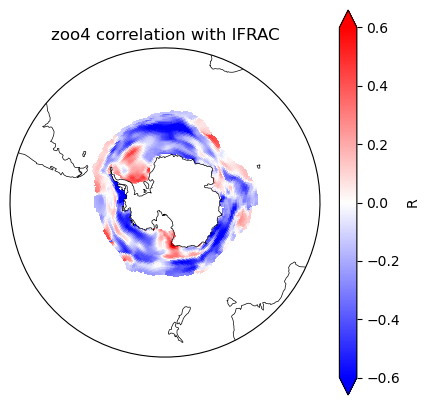

In [28]:
fig = plt.figure(figsize=(5,5))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_ifrac_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo4 correlation with IFRAC')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')


In [31]:
ifrac_sam_ann_corr = xr.corr(ds.IFRAC, da_sam, dim='time')
ifrac_sam_ann_corr = ifrac_sam_ann_corr.squeeze()

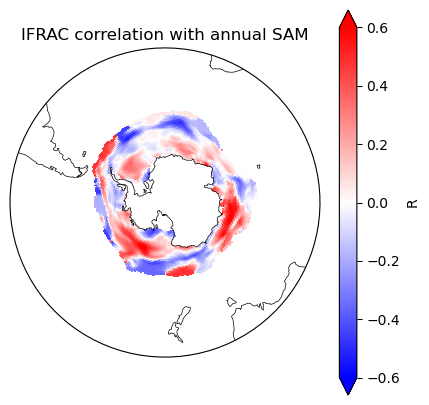

In [32]:
fig = plt.figure(figsize=(5,5))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, ifrac_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('IFRAC correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')
